In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
import os
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [2]:
import fastai
from fastai import *
from fastai.vision import *
import cv2
from tensorflow.keras.applications.inception_v3 import preprocess_input

# from fastai.callbacks import *

In [3]:
config = tf.compat.v1.ConfigProto(gpu_options =
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

3662 images found of 3662 total


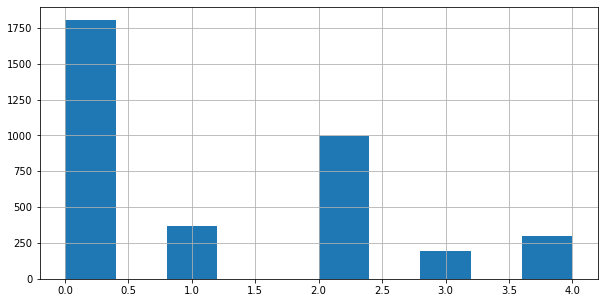

In [4]:
base_image_dir = os.path.join('/home/jupyter')

retina_df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
retina_df['path'] = retina_df['id_code'].map(lambda x: os.path.join(base_image_dir,'train_images',
                                                         '{}.png'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']].drop_duplicates()
retina_df['level'] = retina_df['diagnosis'].map(lambda x: str(x))
# retina_df
retina_df['diagnosis'].hist(figsize = (10, 5))
plt.show()

In [5]:
retina_df

,id_code,diagnosis,path,exists,level
0,000c1434d8d7,2,/home/jupyter/train_images/000c1434d8d7.png,True,2
1,001639a390f0,4,/home/jupyter/train_images/001639a390f0.png,True,4
2,0024cdab0c1e,1,/home/jupyter/train_images/0024cdab0c1e.png,True,1
3,002c21358ce6,0,/home/jupyter/train_images/002c21358ce6.png,True,0
4,005b95c28852,0,/home/jupyter/train_images/005b95c28852.png,True,0
...,...,...,...,...,...
3657,ffa47f6a7bf4,2,/home/jupyter/train_images/ffa47f6a7bf4.png,True,2
3658,ffc04fed30e6,0,/home/jupyter/train_images/ffc04fed30e6.png,True,0
3659,ffcf7b45f213,2,/home/jupyter/train_images/ffcf7b45f213.png,True,2
3660,ffd97f8cd5aa,0,/home/jupyter/train_images/ffd97f8cd5aa.png,True,0


New Data Size: 10000 Old Size: 3662
train 8000 validation 2000


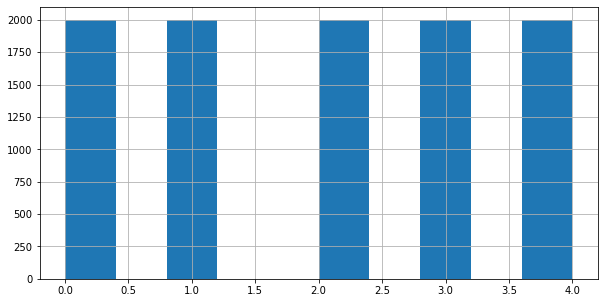

In [6]:
from sklearn.model_selection import train_test_split
raw_df = retina_df.groupby(['diagnosis']).apply(lambda x: x.sample(n = 2000, replace = True)
                                                      ).reset_index(drop = True)
# raw_df.drop_duplicates()
# a = raw_df.groupby('id_code').count()>1
# price = a[a['diagnosis'] == True].index
# repeat_df = raw_df[raw_df['id_code'].isin(price)]   #show duplicated elements

print('New Data Size:', raw_df.shape[0], 'Old Size:', retina_df.shape[0])

train_df, valid_df = train_test_split(raw_df,
                                   test_size = 0.2,
                                   random_state = 2020)
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

raw_df['diagnosis'].hist(figsize = (10, 5))
plt.show()

In [7]:
IMG_SIZE = 512

def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4 , 128)
        
    return preprocess_input(image)

def auto_crop(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        return preprocess_input(img)

# def _load_format(path, convert_mode, after_open)->Image:
#     image = cv2.imread(path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = crop_image_from_gray(image)
#     image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
#     image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0), 10) ,-4 ,128)
                    
#     return Image(pil2tensor(image, np.float32).div_(255)) #return fastai Image format

# vision.data.open_image = _load_format

Found 8000 validated image filenames belonging to 5 classes.
Found 2000 validated image filenames belonging to 5 classes.
(16, 512, 512, 3)
(16, 5)


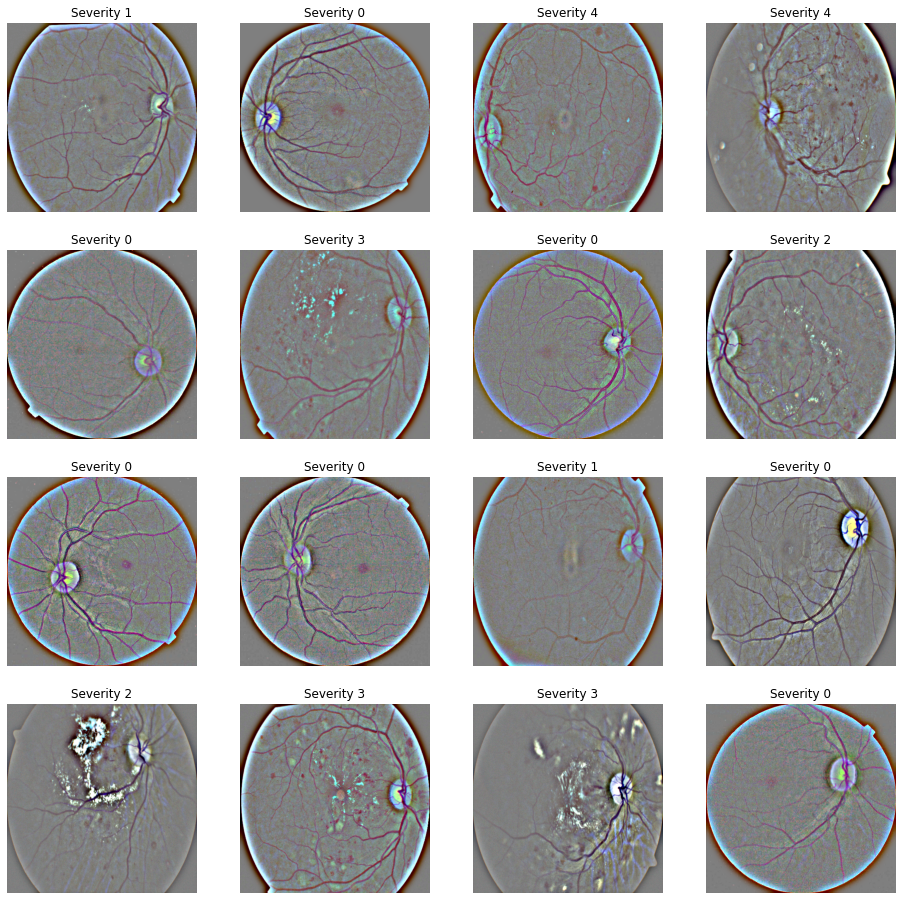

In [8]:
batch_size = 16

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0, 
    horizontal_flip=True,
    vertical_flip=True, 
    # preprocess_input for no other preprocessing method; 
    # load_ben_color for graham pre-process;
    # auto_crop for auto cropping the image;
    preprocessing_function=load_ben_color,
    data_format="channels_last")
train_generator = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='level',
                                                    target_size=(IMG_SIZE,IMG_SIZE),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical')

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0, 
    horizontal_flip=False,
    vertical_flip=False, 
    # preprocess_input for no other preprocessing method; 
    # load_ben_color for graham pre-process;
    # auto_crop for auto cropping the image;
    preprocessing_function=load_ben_color,
    data_format="channels_last")
valid_generator = valid_datagen.flow_from_dataframe(valid_df, x_col='path', y_col='level',
                                                    target_size=(IMG_SIZE,IMG_SIZE),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
print(train_generator)
t_x, t_y = next(train_generator)
input_shape=t_x.shape[1:]
num_classes=t_y.shape[1]
print(t_x.shape)
print(t_y.shape)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')
#     print(c_x.dtype)
plt.show()

In [9]:
# Model Define
from tensorflow.keras.applications.xception import Xception as PTModel
# from tensorflow.keras.applications.vgg16 import VGG16 as PTModel
# from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
# from tensorflow.keras.applications.inception_v3 import InceptionV3 as PTModel
# from tensorflow.python.keras.applications.efficientnet import EfficientNetB3 as PTModel
# from tensorflow.keras.applications.resnet50 import ResNet50 as PTModel
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from tensorflow.keras import Model


in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')

# Turn on and off model trainability
base_pretrained_model.trainable = False
# pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)


##################################Comment out for no attention mechanism######################################
# attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
# attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
# attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
# attn_layer = Conv2D(1, 
#                     kernel_size = (1,1), 
#                     padding = 'valid', 
#                     activation = 'sigmoid')(attn_layer)

# pt_depth = 2048 # 2048 for Inception, Xception; 1536 for EfficientNet, InceptionResNetV2
# # fan it out to all of the channels
# up_c2_w = np.ones((1, 1, 1, pt_depth))
# up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
#                activation = 'linear', use_bias = False, weights = [up_c2_w])
# up_c2.trainable = False
# attn_layer = up_c2(attn_layer)

# mask_features = multiply([attn_layer, bn_features])
# gap_features = GlobalAveragePooling2D()(mask_features)
# gap_mask = GlobalAveragePooling2D()(attn_layer)
# # to account for missing values from the attention model
# gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
# gap_dr = Dropout(0.25)(gap)

##################################Comment out for attention machanism added####################################
gap_dr = GlobalAveragePooling2D()(pt_features)
gap_dr = Dropout(0.2)(gap_dr)

###############################################################################################################
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])

from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', 
                     loss = 'categorical_crossentropy',
                     metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                

Using TensorFlow backend.


In [10]:
# train
weight_path="{}_weights_best.hdf5".format('xception_autocrop')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='auto', save_weights_only=True)

# reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', cooldown=5, min_lr=0.0001)
# early = EarlyStopping(monitor="val_loss", mode="min", patience=15) 
callbacks_list = [checkpoint]


# load the best version of the model
retina_model.load_weights(weight_path)

retina_model.fit(train_generator, 
                 steps_per_epoch = train_df.shape[0]//batch_size,
                 validation_data = valid_generator,
                 validation_steps = valid_df.shape[0]//batch_size,
                 epochs=50,
                 verbose=1,
                 callbacks = callbacks_list,
                 workers = 8
                )



retina_model.save('xception_autocrop_retina_model.h5')

Epoch 1/50
500/500 [==============================] - ETA: 0s - loss: 0.4123 - categorical_accuracy: 0.8536 - top_2_accuracy: 0.9629
Epoch 00001: val_loss improved from inf to 0.51200, saving model to xception_autocrop_weights_best.hdf5
500/500 [==============================] - 1158s 2s/step - loss: 0.4123 - categorical_accuracy: 0.8536 - top_2_accuracy: 0.9629 - val_loss: 0.5120 - val_categorical_accuracy: 0.8065 - val_top_2_accuracy: 0.9550
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 0.3354 - categorical_accuracy: 0.8866 - top_2_accuracy: 0.9775
Epoch 00002: val_loss improved from 0.51200 to 0.28024, saving model to xception_autocrop_weights_best.hdf5
500/500 [==============================] - 1153s 2s/step - loss: 0.3354 - categorical_accuracy: 0.8866 - top_2_accuracy: 0.9775 - val_loss: 0.2802 - val_categorical_accuracy: 0.9050 - val_top_2_accuracy: 0.9810
Epoch 3/50
500/500 [==============================] - ETA: 0s - loss: 0.2864 - categorical_accuracy:

In [10]:
# Validation result recheck block, please firsly run the model block

retina_model.load_weights('xception_autocrop_weights_best.hdf5') # load the best weights
# retina_model.load_weights('xception_trainable_weights_best.hdf5')

retina_model.evaluate(valid_generator,
                      verbose=1,
                      workers=8)



125/125 [==============================] - 189s 2s/step - loss: 0.0758 - categorical_accuracy: 0.9755 - top_2_accuracy: 0.9970


[0.07575118541717529, 0.9754999876022339, 0.996999979019165]